In [25]:
import re
import csv
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
#import nltk
from collections import Counter 
import matplotlib.pyplot as plt

# Lecture des données et construction des train, dev et test sets

In [2]:
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
    return string.strip()

In [3]:
##On transforme les 3 colonnes en 1 : url, titre et le texte deviennent un seul élément
def read_data(filename):
    data = []
    labels = []
    with open(filename, encoding="utf8", newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            txt = clean_str(row[2])
            txt = " ".join(txt.split("\n"))
#             d = clean_str(row[0])+" "+clean_str(row[1])
            labels.append(row[3])
            data.append(txt)    
    data.pop(0)
    labels.pop(0)
    labels = [float(l) for l in labels]
    return np.array(data), np.array(labels)

In [4]:
data, labels = read_data("data.csv")

In [5]:
print(data[0])

image copyright getty images on sunday morning , donald trump went off on a twitter tirade against a member of his own party this , in itself , is n't exactly huge news it 's far from the first time the president has turned his rhetorical cannons on his own ranks this time , however , his attacks were particularly biting and personal he essentially called tennessee senator bob corker , the chair of the powerful senate foreign relations committee , a coward for not running for re election he said mr corker begged for the president 's endorsement , which he refused to give he wrongly claimed that mr corker 's support of the iranian nuclear agreement was his only political accomplishment unlike some of his colleagues , mr corker free from having to worry about his immediate political future did n't hold his tongue skip twitter post by senbobcorker it 's a shame the white house has become an adult day care center someone obviously missed their shift this morning senator bob corker \( senbo

In [6]:
print(data.shape)
fake_data = data[labels==0]
real_data = data[labels==1]
fake_labels = labels[labels==0]
real_labels = labels[labels==1]
print("Nombre de fake news : {}".format(len(fake_data)))
print("Nombre de news correctes : {}".format(len(real_data)))


(4009,)
Nombre de fake news : 2137
Nombre de news correctes : 1872


In [7]:
print(fake_data.shape)

(2137,)


In [8]:
train_data = np.array([*real_data[:int(len(real_data)*0.8)],*fake_data[:int(len(fake_data)*0.8)]])
train_labels = np.array([*real_labels[:int(len(real_labels)*0.8)],*fake_labels[:int(len(fake_labels)*0.8)]], dtype=np.float32)

dev_data = np.array([*real_data[int(len(real_data)*0.8):int(len(real_data)*0.9)], *fake_data[int(len(fake_data)*0.8):int(len(fake_data)*0.9)]])
dev_labels = np.array([*real_labels[int(len(real_labels)*0.8):int(len(real_labels)*0.9)], *fake_labels[int(len(fake_labels)*0.8):int(len(fake_labels)*0.9)]], dtype=np.float32)

test_data = np.array([*real_data[int(len(real_data)*0.9):], *fake_data[int(len(fake_data)*0.9):]])
test_labels = np.array([*real_labels[int(len(real_labels)*0.9):], *fake_labels[int(len(fake_labels)*0.9):]], dtype=np.float32)

In [9]:
print("taille du train set : {}".format(len(train_data)))
print("taille du dev set : {}".format(len(dev_data)))
print("taille du test set : {}".format(len(test_data)))

taille du train set : 3206
taille du dev set : 401
taille du test set : 402


# Construction du vocabulaire

In [10]:
txt = [w for txt in train_data for w in txt.split()]
          
# token = nltk.word_tokenize(txt)
words = Counter(txt)
words = sorted(words, key=words.get, reverse=True)
words = ['_PAD','_UNK'] + words
vocab_size = len(words)
word2idx = {o:i for i,o in enumerate(words)}
word2idx["UNK"]=len(word2idx)
print("vocab size : ",vocab_size)

vocab size :  43464


In [11]:
train_data = [[word2idx[w] for w in news.split()] for news in train_data]
dev_data = [[word2idx[w] if w in word2idx else 0 for w in news.split()] for news in dev_data]
test_data = [[word2idx[w] if w in word2idx else 0 for w in news.split()] for news in test_data]

In [12]:
def pad_input(data, seq_len):
    features = np.zeros((len(data), seq_len), dtype=int)
    for ii, review in enumerate(data):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

# Padding
## on pad les input pour pouvoir créer des datasets pytorch et simplifier l'apprentissage (fonction de train plus claire, batch plus facile, etc)
on peut tester plusieurs taille de padding : input le plus grand, moyen, min, ou arbitraire du genre 200, 500, etc. On peut aussi ainsi réduire le temps de train.

In [13]:
# train_seq_len = max([len(s) for s in train_data])
# dev_seq_len = max([len(s) for s in dev_data])
# test_seq_len = max([len(s) for s in test_data])

# train_data = pad_input(train_data, train_seq_len)
# dev_data = pad_input(dev_data, dev_seq_len)
# test_data = pad_input(test_data, test_seq_len)

seq_len = 200


train_data = pad_input(train_data, seq_len)
dev_data = pad_input(dev_data, seq_len)
test_data = pad_input(test_data, seq_len)

In [14]:
train_data = TensorDataset(th.from_numpy(train_data).type(th.LongTensor), th.from_numpy(train_labels))
dev_data = TensorDataset(th.from_numpy(dev_data).type(th.LongTensor), th.from_numpy(dev_labels))
test_data = TensorDataset(th.from_numpy(test_data).type(th.LongTensor), th.from_numpy(test_labels))

batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
dev_loader = DataLoader(dev_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# CBOW Classifieur

In [15]:
class L_CBOW_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(L_CBOW_classifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.l1 = nn.Linear(embedding_dim, 1)
        
        nn.init.xavier_uniform_(self.l1.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.l1.bias.data)  # Xavier/Glorot init for tanh
        
    def forward(self, inputs):
        inputs = self.embedding(inputs)
        inputs = th.sum(inputs, dim=1)
        out = th.sigmoid(self.l1(inputs))
        return out

In [16]:
class C_CBOW_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(C_CBOW_classifier, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(1, 20, 5, 1)
        self.conv2 = nn.Conv1d(20, 50, 5, 1)
        self.dense1 = nn.Linear(450, 250)
        self.dense2 = nn.Linear(250, 64)
        self.dense3 = nn.Linear(64, 1)

    def forward(self, x):

        x = self.embeddings(x)
        x = th.sum(x, dim=0)
        x = x.view(1, 1,-1)
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2, 2)
        x = x.view(-1, 450)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        return th.sigmoid(x)

In [16]:
loss_fn = nn.BCELoss()
lr = 1e-2
l_cbow = L_CBOW_classifier(len(word2idx), 50)
cbow_train_accuracies = []
cbow_train_losses = []
cbow_dev_accuracies = []
cbow_dev_losses = []

In [17]:
def train_cbow(model, max_epochs=20):
    optim = th.optim.Adam(params=model.parameters(), lr =lr, weight_decay=1e-4)
#     model.train()
    
    for e in range(max_epochs):
        train_accuracy = 0
        dev_accuracy = 0
        train_mean_loss = 0
        dev_mean_loss = 0
        
        n=0
        for x, labels in train_loader:
            n+=batch_size
            preds = model(x)
            loss = loss_fn(preds, labels)

            train_mean_loss+=loss.item()
            optim.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optim.step()
            
            for pred, label in zip(preds, labels):
                if((pred<0.5 and label==0) or (pred>0.5 and label == 1)):
                    train_accuracy+=1
                
            if(n%250==0):
                print("step : {}/{} ".format(n, len(train_data)))
                print("step accuracy : ", train_accuracy/n)
                print("step loss : ", train_mean_loss/n)
                
        ###Dev test
        for x, labels in dev_loader:
            preds = model(x)
            loss = loss_fn(preds, labels)
            dev_mean_loss+=loss.item()
            for pred, label in zip(preds, labels):
                if((pred<0.5 and label==0) or (pred>0.5 and label == 1)):
                    dev_accuracy+=1
                    
        cbow_train_accuracies.append(train_accuracy/len(train_data))
        cbow_train_losses.append(train_mean_loss/len(train_data))
        cbow_dev_accuracies.append(dev_accuracy/len(dev_data))
        cbow_dev_losses.append(dev_mean_loss/len(dev_data))
        
        
        print("EPOCH {}".format(e+1))
        print("Train Accuracy : ",train_accuracy/len(train_data))
        print("Dev Accuracy : ",dev_accuracy/len(dev_data))
        print("Train Mean loss : ",train_mean_loss/len(train_data))
        print("Dev Mean loss : ",dev_mean_loss/len(dev_data))
        print("----------------------------------------")

In [18]:
train_cbow(l_cbow)

C:\Users\Timothée\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


step : 250/3206 
step accuracy :  0.44
step loss :  0.29926047134399414
step : 500/3206 
step accuracy :  0.498
step loss :  0.2653045663833618
step : 750/3206 
step accuracy :  0.5266666666666666
step loss :  0.24070993932088217
step : 1000/3206 
step accuracy :  0.546
step loss :  0.2362094488143921
step : 1250/3206 
step accuracy :  0.5384
step loss :  0.23339569778442382
step : 1500/3206 
step accuracy :  0.5533333333333333
step loss :  0.22791853268941242
step : 1750/3206 
step accuracy :  0.544
step loss :  0.23114332689557757
step : 2000/3206 
step accuracy :  0.556
step loss :  0.22447829365730285
step : 2250/3206 
step accuracy :  0.5462222222222223
step loss :  0.22889489809672037
step : 2500/3206 
step accuracy :  0.5544
step loss :  0.2231646255493164
step : 2750/3206 
step accuracy :  0.5683636363636364
step loss :  0.21415970230102538
step : 3000/3206 
step accuracy :  0.5836666666666667
step loss :  0.20180950609842938


C:\Users\Timothée\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Timothée\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


step : 3250/3206 
step accuracy :  0.5876923076923077
step loss :  0.1920277486214271
EPOCH 1
Train Accuracy :  0.5957579538365565
Dev Accuracy :  0.6758104738154613
Train Mean loss :  0.19466318871479665
Dev Mean loss :  0.19550638365329354
----------------------------------------
step : 250/3206 
step accuracy :  0.776
step loss :  0.06374040818214416
step : 500/3206 
step accuracy :  0.82
step loss :  0.053368520140647885
step : 750/3206 
step accuracy :  0.828
step loss :  0.054642886718114216
step : 1000/3206 
step accuracy :  0.821
step loss :  0.0548591256737709
step : 1250/3206 
step accuracy :  0.8184
step loss :  0.05398664231300354
step : 1500/3206 
step accuracy :  0.8146666666666667
step loss :  0.05612600417931875
step : 1750/3206 
step accuracy :  0.8194285714285714
step loss :  0.05675949079649789
step : 2000/3206 
step accuracy :  0.8285
step loss :  0.05395495331287384
step : 2250/3206 
step accuracy :  0.8337777777777777
step loss :  0.05146600822607676
step : 2500/3

step : 2000/3206 
step accuracy :  0.981
step loss :  0.0028827764817451113
step : 2250/3206 
step accuracy :  0.9813333333333333
step loss :  0.002693442226130426
step : 2500/3206 
step accuracy :  0.9816
step loss :  0.0026842059800831976
step : 2750/3206 
step accuracy :  0.9774545454545455
step loss :  0.0033794204823334026
step : 3000/3206 
step accuracy :  0.978
step loss :  0.0031872625818476007
step : 3250/3206 
step accuracy :  0.9624615384615385
step loss :  0.00341991911885113
EPOCH 8
Train Accuracy :  0.975670617592015
Dev Accuracy :  0.9301745635910225
Train Mean loss :  0.003466855001954514
Dev Mean loss :  0.015296654139722947
----------------------------------------
step : 250/3206 
step accuracy :  0.964
step loss :  0.009421022300758978
step : 500/3206 
step accuracy :  0.96
step loss :  0.007049689792637537
step : 750/3206 
step accuracy :  0.9706666666666667
step loss :  0.00522377871983114
step : 1000/3206 
step accuracy :  0.964
step loss :  0.005827129244550974
s

step : 500/3206 
step accuracy :  0.91
step loss :  0.032025485701567956
step : 750/3206 
step accuracy :  0.9293333333333333
step loss :  0.02422890132147222
step : 1000/3206 
step accuracy :  0.939
step loss :  0.02028363655967928
step : 1250/3206 
step accuracy :  0.9392
step loss :  0.017797667851942606
step : 1500/3206 
step accuracy :  0.9466666666666667
step loss :  0.01517091753388407
step : 1750/3206 
step accuracy :  0.952
step loss :  0.013165847180810009
step : 2000/3206 
step accuracy :  0.9565
step loss :  0.012107225227085714
step : 2250/3206 
step accuracy :  0.9586666666666667
step loss :  0.011404964860059541
step : 2500/3206 
step accuracy :  0.9608
step loss :  0.01067714061424752
step : 2750/3206 
step accuracy :  0.9636363636363636
step loss :  0.009948946611794145
step : 3000/3206 
step accuracy :  0.9656666666666667
step loss :  0.009210020388321126
step : 3250/3206 
step accuracy :  0.9541538461538461
step loss :  0.008561397886682615
EPOCH 15
Train Accuracy : 

In [105]:
print(max(dev_accuracies))

0.970074812967581


In [19]:
def test_cbow(model, test_data, test_labels):
    acc = 0
    test_mean_loss = 0
    
    for x, labels in test_loader:
            
            preds = model(x)
            loss = loss_fn(preds, labels)
            test_mean_loss+=loss.item()
            for pred, label in zip(preds, labels):
                if((pred<0.5 and label==0) or (pred>0.5 and label == 1)):
                    acc+=1
    print("Test accuracy : ", acc/len(test_data))
    print("Test mean loss : ", test_mean_loss/len(test_data))

In [65]:
test_cbow(l_cbow, test_data, test_labels)

Test accuracy :  0.9502487562189055
Test mean loss :  0.011409410724963123


C:\Users\Timothée\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Timothée\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


## On plot les résultats

In [76]:
def plot_train_results(train_acc, dev_acc, train_loss, dev_loss, model_name):
    xaxis = [i for i in range(1,21)]
    acc_file_name = "acc_"+"_".join(model_name.split())+".png"
    loss_file_name = "loss_"+"_".join(model_name.split())+".png"
    
    plt.plot(xaxis,train_acc, label= "Train accuracy")
    plt.plot(xaxis,dev_acc, label="Dev accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy on train and dev set over 20 epochs for a "+model_name)
    plt.savefig(acc_file_name)
    plt.show()
    
    plt.plot(train_loss, label= "Train loss")
    plt.plot(dev_loss, label="Dev loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Mean loss on train and dev set over 20 epochs for a "+model_name)
    plt.savefig(loss_file_name)
    plt.show()

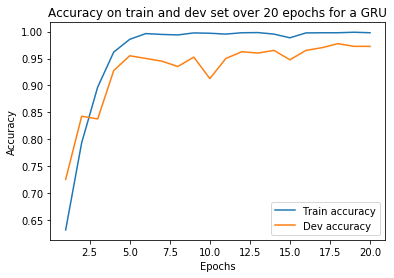

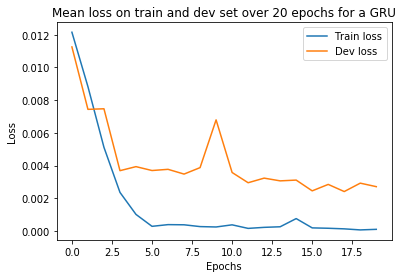

In [77]:
plot_train_results(rnn_train_accuracies, rnn_dev_accuracies, rnn_train_losses, rnn_dev_losses, "GRU")

# Un classifieur RNN classique (GRU) 

In [29]:
class GRU_classifier(nn.Module):
    def __init__(self, nb_cells, hidden_size, vocab_size, embedding_dim, rnn_dropout, bidirectional=False):
        super(GRU_classifier, self).__init__()
        
        self.nb_cells = nb_cells
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, nb_cells, batch_first = True, dropout=rnn_dropout,bidirectional=bidirectional)

        if bidirectional:    
            self.fc = nn.Linear(2*hidden_size, 1)
        else:
            self.fc = nn.Linear(hidden_size, 1)
        self.is_bidirectional = bidirectional 
        self.dropout = nn.Dropout(0.2)
        nn.init.xavier_uniform_(self.fc.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.fc.bias.data)  # Xavier/Glorot init for tanh
        
            
    
    def forward(self, inputs, hidden):
        batch_size = inputs.size(0)
        embeds = self.embedding(inputs)
        rnn_out, hidden = self.gru(embeds, hidden)
        
        out = self.dropout(rnn_out)

        out = self.fc(out)
        out = th.sigmoid(out)
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        #hidden = th.Tensor(self.nb_cells, batch_size, self.hidden_size)
        if self.is_bidirectional:
            hidden = weight.new(2*self.nb_cells, batch_size, self.hidden_size).zero_()
        else:
            hidden = weight.new(self.nb_cells, batch_size, self.hidden_size).zero_()
        return hidden

# La même classe mais avec de l'attention
on implémente une version simplifiée de l'attention présentée dans ce papier : https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf 

In [34]:
class GRU_with_attention_classifier(nn.Module):
    def __init__(self, nb_cells, hidden_size, vocab_size, embedding_dim, rnn_dropout, bidirectional=False):
        super(GRU_with_attention_classifier, self).__init__()
        
        self.nb_cells = nb_cells
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, nb_cells, batch_first = True, dropout=rnn_dropout,bidirectional=bidirectional)
        
        
            
        self.is_bidirectional = bidirectional 
        self.dropout = nn.Dropout(0.2)
        #nn.init.xavier_uniform_(self.fc.weight.data)  # Xavier/Glorot init for tanh
        #nn.init.zeros_(self.fc.bias.data)  # Xavier/Glorot init for tanh
        
        if bidirectional:    
            self.fc_attn1 = nn.Linear(2*hidden_size, 100)
        else:
            self.fc_attn1 = nn.Linear(hidden_size, 100)
            
        self.fc_attn2 = nn.Linear(100,1, bias=False)    
        self.fc_attn3 = nn.Linear(hidden_size, 1)
    
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()
        
    def forward(self, inputs, hidden):
        batch_size = inputs.size(0)
        embeds = self.embedding(inputs)
        rnn_out, hidden = self.gru(embeds, hidden)
        
        out = self.dropout(rnn_out)
        attention_weight = self.fc_attn1(out)
        attention_weight = self.tanh(attention_weight)
        attention_weight = self.softmax(self.fc_attn2(attention_weight))
        out = (out*attention_weight).sum(dim=1)
        out = self.fc_attn3(out)
        out = th.sigmoid(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        #hidden = th.Tensor(self.nb_cells, batch_size, self.hidden_size)
        if self.is_bidirectional:
            hidden = weight.new(2*self.nb_cells, batch_size, self.hidden_size).zero_()
        else:
            hidden = weight.new(self.nb_cells, batch_size, self.hidden_size).zero_()
        return hidden

In [66]:
##Hyper-paramètres
nb_cells = 1
hidden_size = 32
embedding_dim = 10
learning_rate = 1e-2
loss_fn = nn.BCELoss()
#m = GRU_with_attention_classifier(nb_cells, hidden_size, vocab_size, embedding_dim, 0.0, bidirectional=False)
m = GRU_classifier(nb_cells, hidden_size, vocab_size, embedding_dim, 0.0, bidirectional=False)

rnn_train_accuracies = []
rnn_train_losses = []
rnn_dev_accuracies = []
rnn_dev_losses = []

print(m)

GRU_classifier(
  (embedding): Embedding(43464, 10)
  (gru): GRU(10, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2)
)


In [41]:
def train_rnn(model, batch_size,lr, max_epochs=20, conv=False):
    optim = th.optim.Adam(params=model.parameters(), lr=lr, weight_decay=1e-4)
    model.train()
    best_dict = model.state_dict()
    best_acc = 0
    for i in range(max_epochs):
        train_accuracy = 0
        dev_accuracy = 0
        train_mean_loss = 0
        dev_mean_loss = 0

        n = 0 

        for x, labels in train_loader:
            loc_batch_size = x.size(0)
            h = model.init_hidden(loc_batch_size)
            
            optim.zero_grad()
            h = h.data
            
            n+=loc_batch_size
            
            preds, _ = model(x, h)  
            loss = loss_fn(preds, labels)
            h = h.detach()
            train_mean_loss+=loss.item()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optim.step()

            for pred, label in zip(preds, labels):
                if((label==1 and pred>0.5) or(label==0 and pred<0.5)):
                    train_accuracy+=1
        
            if(n%250==0):
                print("step : {}/{} ".format(n, len(train_data)))
                print("step accuracy : ", train_accuracy/n)
                print("step loss : ", train_mean_loss/n)
                
        for x, labels in dev_loader:
            loc_batch_size = x.size(0)
            h = model.init_hidden(loc_batch_size)
            preds, _ = model(x, h)
            loss = loss_fn(preds, labels)

            dev_mean_loss+=loss.item()
            
            for pred, label in zip(preds, labels):
                if((label==1 and pred>0.5) or(label==0 and pred<0.5)):
                    dev_accuracy+=1
        
        if(i==0):
            best_dict=model.state_dict()
            best_acc=dev_accuracy/len(dev_data)
        else:
            if(best_acc<(dev_accuracy/len(dev_data))):
                best_acc=dev_accuracy/len(dev_data)
                best_dict=model.state_dict()
                print("new best acc")
        
        rnn_train_accuracies.append(train_accuracy/len(train_data))
        rnn_train_losses.append(train_mean_loss/len(train_data))
        rnn_dev_accuracies.append(dev_accuracy/len(dev_data))
        rnn_dev_losses.append(dev_mean_loss/len(dev_data))
        
        print("EPOCH {}".format(i+1))
        print("Train Accuracy : ",train_accuracy/len(train_data))
        print("Dev Accuracy : ",dev_accuracy/len(dev_data))
        print("Train Mean loss : ",train_mean_loss/len(train_data))
        print("Dev Mean loss : ",dev_mean_loss/len(dev_data))
        print("----------------------------------------")
        
#     model.load_state_dict(best_dict)
#     acc = test(model, test_data, conv=conv)
#     stat_dict[model_name][4].append(acc)
#     print("Accuracy on test data : ", acc)
#     return best_dict

In [67]:
train_rnn(m, batch_size, learning_rate)

step : 250/3206 
step accuracy :  0.508
step loss :  0.013862936019897461
step : 500/3206 
step accuracy :  0.544
step loss :  0.013498514533042908
step : 750/3206 
step accuracy :  0.5666666666666667
step loss :  0.013370970408121744
step : 1000/3206 
step accuracy :  0.576
step loss :  0.013281857669353485
step : 1250/3206 
step accuracy :  0.5808
step loss :  0.013131042718887329
step : 1500/3206 
step accuracy :  0.5786666666666667
step loss :  0.013082938194274902
step : 1750/3206 
step accuracy :  0.5874285714285714
step loss :  0.012971991096224104
step : 2000/3206 
step accuracy :  0.596
step loss :  0.012835371017456054
step : 2250/3206 
step accuracy :  0.6022222222222222
step loss :  0.012654444906446669
step : 2500/3206 
step accuracy :  0.6144
step loss :  0.012460497832298278
step : 2750/3206 
step accuracy :  0.624
step loss :  0.012300752954049544
step : 3000/3206 
step accuracy :  0.6273333333333333
step loss :  0.012189014703035355
EPOCH 1
Train Accuracy :  0.63194011

step : 500/3206 
step accuracy :  0.998
step loss :  0.0001338532054796815
step : 750/3206 
step accuracy :  0.9973333333333333
step loss :  0.0001909332935853551
step : 1000/3206 
step accuracy :  0.997
step loss :  0.00018454635347006843
step : 1250/3206 
step accuracy :  0.9976
step loss :  0.00015464180167764426
step : 1500/3206 
step accuracy :  0.996
step loss :  0.00023094839121525485
step : 1750/3206 
step accuracy :  0.9942857142857143
step loss :  0.00033391135731445894
step : 2000/3206 
step accuracy :  0.9935
step loss :  0.0003914191817166284
step : 2250/3206 
step accuracy :  0.9942222222222222
step loss :  0.000360475096023745
step : 2500/3206 
step accuracy :  0.9944
step loss :  0.0003433188223280013
step : 2750/3206 
step accuracy :  0.9945454545454545
step loss :  0.00034622730788859456
step : 3000/3206 
step accuracy :  0.9943333333333333
step loss :  0.00034834836656227707
EPOCH 8
Train Accuracy :  0.9937616968184654
Dev Accuracy :  0.9351620947630923
Train Mean lo

step : 250/3206 
step accuracy :  0.996
step loss :  0.0001539969936129637
step : 500/3206 
step accuracy :  0.992
step loss :  0.0004889125479676295
step : 750/3206 
step accuracy :  0.9853333333333333
step loss :  0.0009966537251020781
step : 1000/3206 
step accuracy :  0.983
step loss :  0.001088057921748259
step : 1250/3206 
step accuracy :  0.9824
step loss :  0.001063413537677843
step : 1500/3206 
step accuracy :  0.9833333333333333
step loss :  0.0009951889847191826
step : 1750/3206 
step accuracy :  0.984
step loss :  0.0009382424636694071
step : 2000/3206 
step accuracy :  0.9855
step loss :  0.0008483770336097223
step : 2250/3206 
step accuracy :  0.9866666666666667
step loss :  0.0008035702079392245
step : 2500/3206 
step accuracy :  0.9876
step loss :  0.0007690900695568417
step : 2750/3206 
step accuracy :  0.9872727272727273
step loss :  0.0007988516699406319
step : 3000/3206 
step accuracy :  0.9876666666666667
step loss :  0.000795569011985208
EPOCH 15
Train Accuracy : 

In [70]:
def test_rnn(model, test_data, test_labels):
    acc = 0
    test_mean_loss = 0
    
    for x, labels in test_loader:
            loc_batch_size = x.size(0)
            h = model.init_hidden(loc_batch_size)
            preds, _ = model(x, h)
            loss = loss_fn(preds, labels)
            test_mean_loss+=loss.item()
            for pred, label in zip(preds, labels):
                if((pred<0.5 and label==0) or (pred>0.5 and label == 1)):
                    acc+=1
    print("Test accuracy : ", acc/len(test_data))
    print("Test mean loss : ", test_mean_loss/len(test_data))

In [71]:
test_rnn(m, test_data, test_labels)

Test accuracy :  0.9825870646766169
Test mean loss :  0.0011151553525874237
